# 実践応用（２）

習うより慣れろ！

ということで、公開されているFXチャートデータをデータフレームとして読み込み、前処理や描写をやってみる。

- mplfinane
  - mplfinaceはmatplotlib風の金融向けグラフ描写ライブラリ
  - キャンドルチャートなどがかける
- pandas_ta
  - pandas_ta（テクニカルアナライズ）は、pandasの時系列データから、金融向けのインジケータやチャートパターンを検出できる！！（なんかすごそう（小並感
  - 類似としてtalib


https://github.com/twopirllc/pandas-ta/pull/693

https://github.com/matplotlib/mplfinance/blob/master/examples/external_axes.ipynb


In [ ]:
! pip install pandas_ta mplfinance

import pandas as pd
import mplfinance as mpf
import pandas_ta as ta
import numpy as np

import shutil
import requests


In [ ]:
r= requests.get('https://forextester.com/templates/data/files/USDJPY.zip')
with open('USDJPY.zip', 'wb') as f:
  f.write(r.content)

shutil.unpack_archive('USDJPY.zip')

odf = pd.read_csv('USDJPY.txt', parse_dates=[['<DTYYYYMMDD>','<TIME>']]).set_index('<DTYYYYMMDD>_<TIME>')
odf

,<TICKER>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DTYYYYMMDD>_<TIME>,,,,,,
2001-01-02 23:03:00,USDJPY,114.43,114.43,114.43,114.43,4
2001-01-02 23:04:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:05:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:07:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:08:00,USDJPY,114.44,114.44,114.44,114.44,4
...,...,...,...,...,...,...
2023-11-30 23:55:00,USDJPY,147.78,147.78,147.78,147.78,4
2023-11-30 23:56:00,USDJPY,147.77,147.77,147.77,147.77,4
2023-11-30 23:57:00,USDJPY,147.76,147.76,147.76,147.76,4


In [ ]:
odf.columns = ['Ticker','Open','High','Low','Close','Vol']
odf

,Ticker,Open,High,Low,Close,Vol
<DTYYYYMMDD>_<TIME>,,,,,,
2001-01-02 23:03:00,USDJPY,114.43,114.43,114.43,114.43,4
2001-01-02 23:04:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:05:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:07:00,USDJPY,114.44,114.44,114.44,114.44,4
2001-01-02 23:08:00,USDJPY,114.44,114.44,114.44,114.44,4
...,...,...,...,...,...,...
2023-11-30 23:55:00,USDJPY,147.78,147.78,147.78,147.78,4
2023-11-30 23:56:00,USDJPY,147.77,147.77,147.77,147.77,4
2023-11-30 23:57:00,USDJPY,147.76,147.76,147.76,147.76,4


In [ ]:
# 4時間足にリサンプル、列ごとに区間のどこのデータを使うか定義

d_ohlc = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
        }


df = odf.loc['2023-04-01':'2023-04-30'].resample('4H').agg(d_ohlc)
p_df = predict_df.loc['2021-04-01':'2023-04-30']
df  = pd.merge(df,p_df,on='<DTYYYYMMDD>_<TIME>',how='left')

df[['forecast','forecast_upper','forecast_lower']] = df[['forecast','forecast_upper','forecast_lower']].fillna(method='ffill')
df


,Open,High,Low,Close,actual,forecast,forecast_lower,forecast_upper
<DTYYYYMMDD>_<TIME>,,,,,,,,
2023-04-02 20:00:00,164.29,164.29,163.40,163.56,NaN,NaN,NaN,NaN
2023-04-03 00:00:00,163.68,163.98,163.51,163.92,164.86,165.386078,164.305086,166.467071
2023-04-03 04:00:00,163.93,164.70,163.88,164.63,NaN,165.386078,164.305086,166.467071
2023-04-03 08:00:00,164.64,164.86,164.41,164.57,NaN,165.386078,164.305086,166.467071
2023-04-03 12:00:00,164.56,164.58,163.75,164.18,NaN,165.386078,164.305086,166.467071
...,...,...,...,...,...,...,...,...
2023-04-30 04:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901
2023-04-30 08:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901
2023-04-30 12:00:00,NaN,NaN,NaN,NaN,NaN,170.528743,168.920586,172.136901


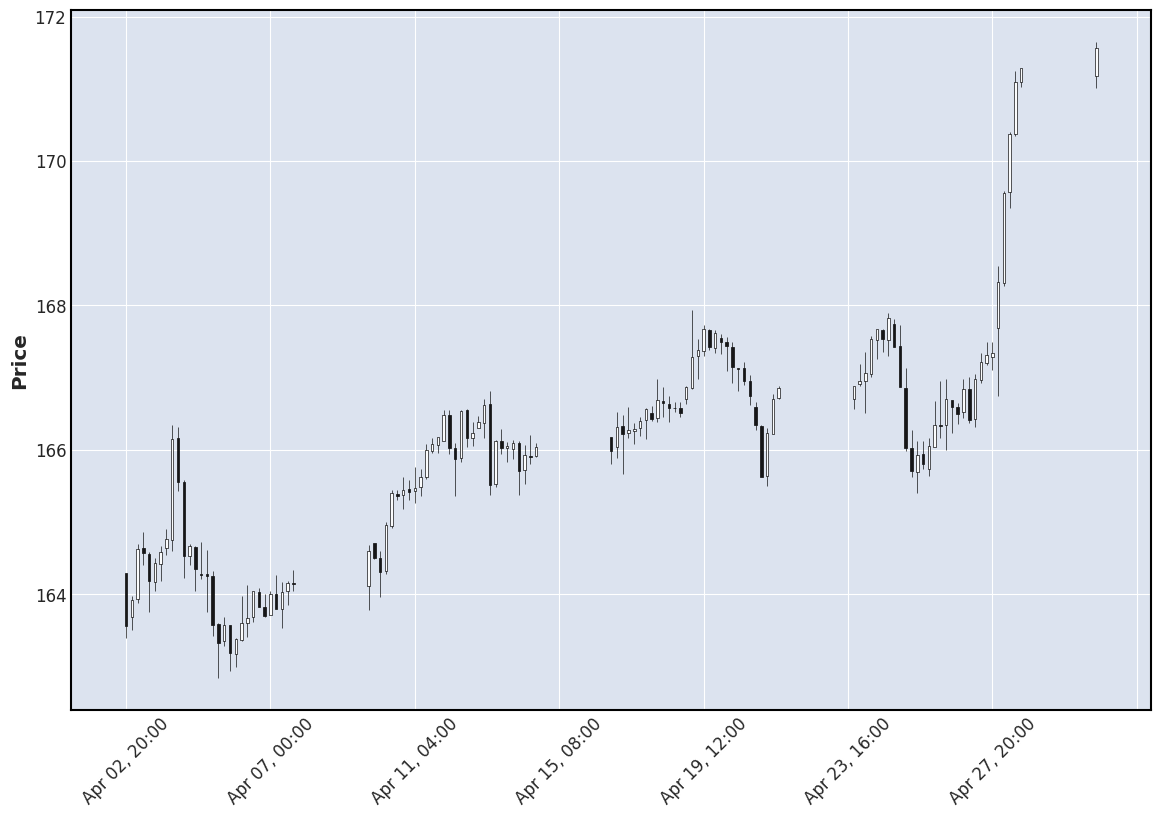

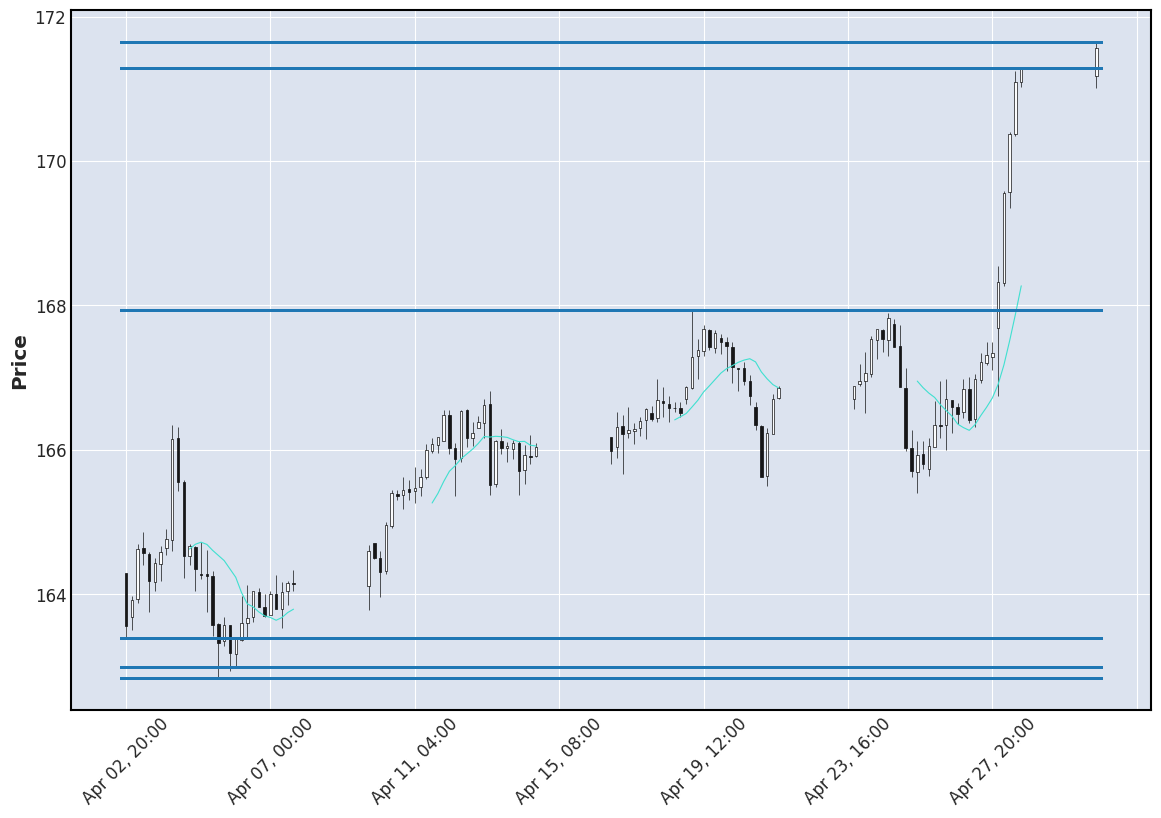

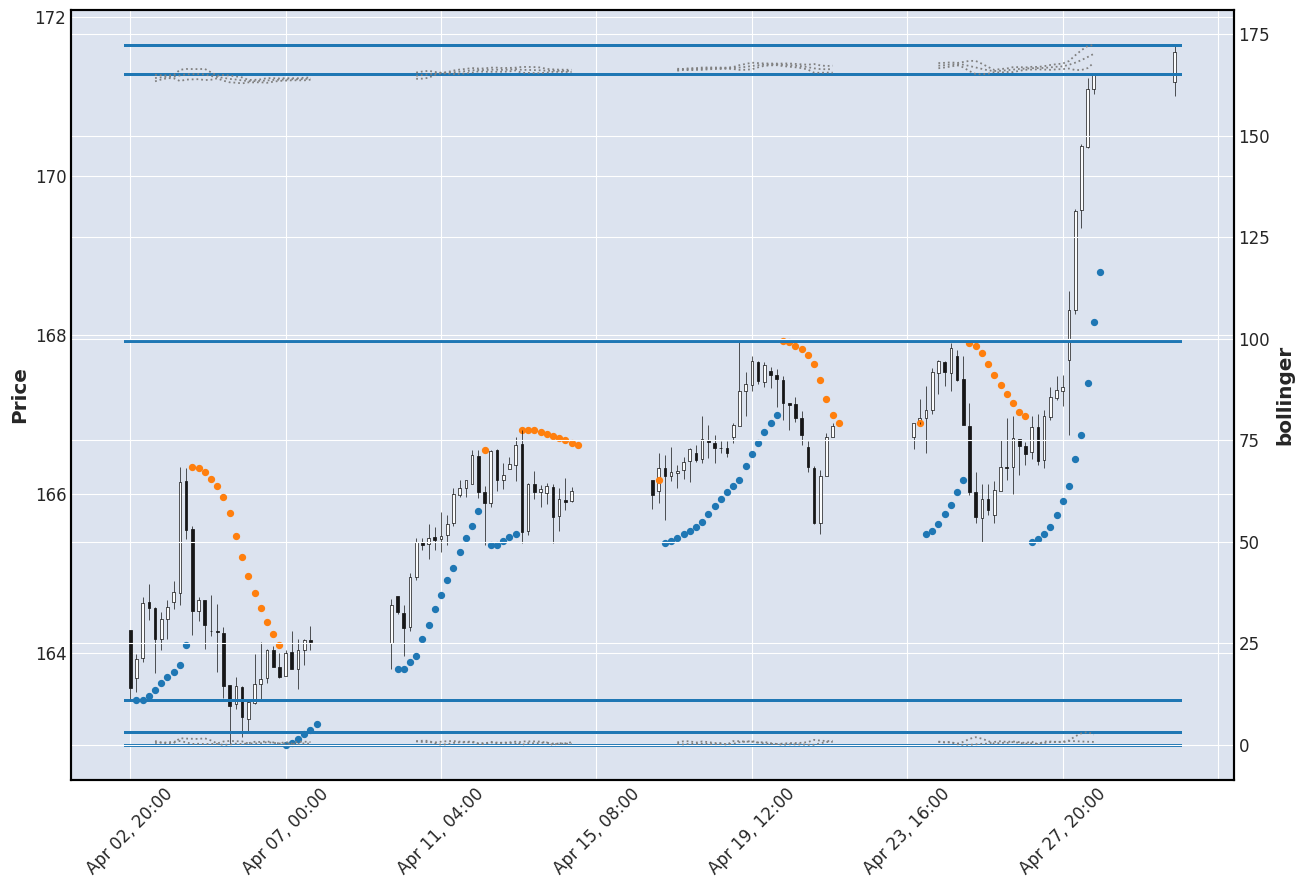

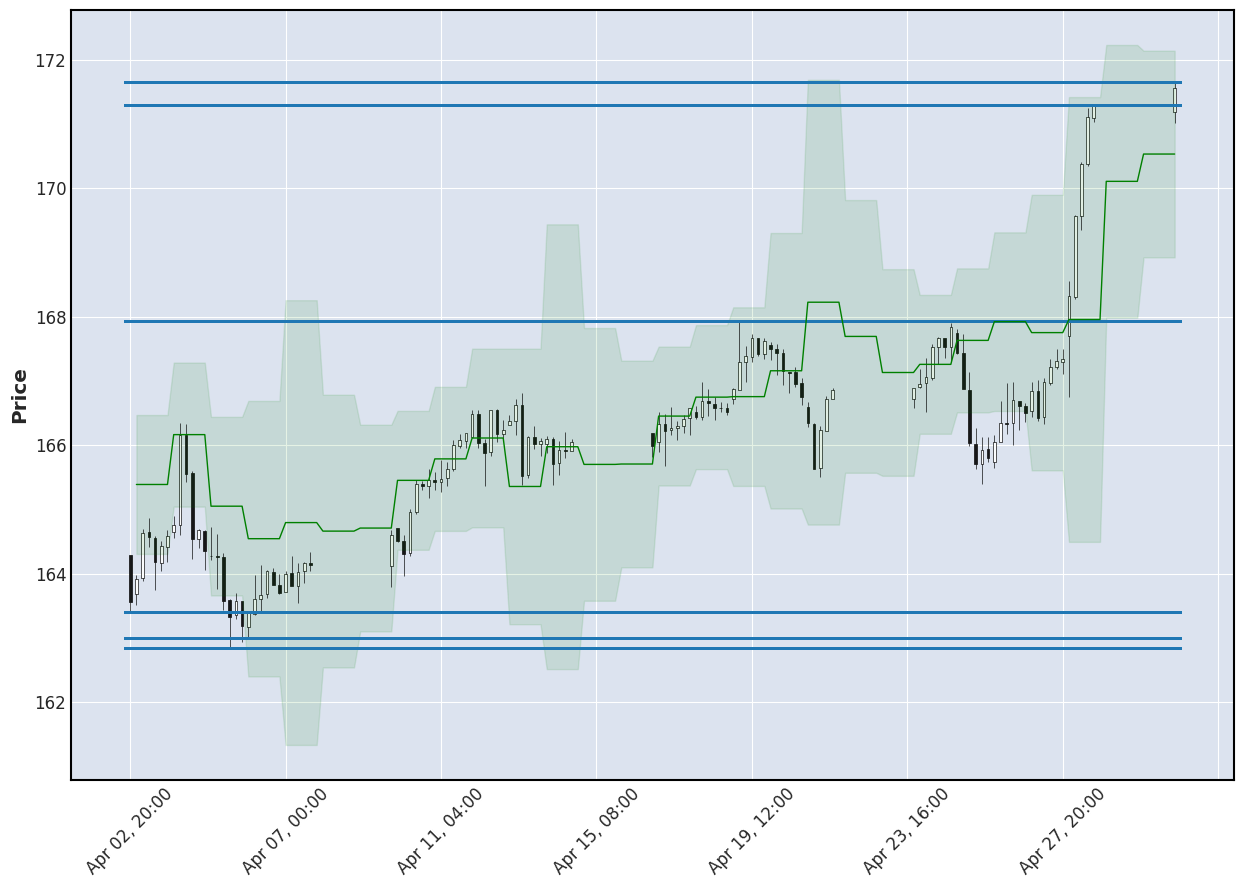

In [ ]:
# インジケータの用意

rsi = ta.momentum.rsi(df['Close'],length=3)

psar = ta.trend.psar(high=df['High'],low=df['Low'])


# 一番簡単な例
# 区間の最大、最小値に水平線を引く

mpf.plot(df,type='candle',figsize=(15,10))
#mpf.plot(df,type='candle',mav=12,hlines=[df['High'].max(),df['Low'].min()])
mpf.plot(
        df,
        type='candle',
        figsize=(15,10),
        mav=12,
        hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
        )


# matplotlib的な書き方で、PSARを描写する
fig = mpf.figure(figsize=(15,10))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
op = [
      mpf.make_addplot(psar['PSARl_0.02_0.2'],ax=ax1,type='scatter'),
      mpf.make_addplot(psar['PSARs_0.02_0.2'],ax=ax1,type='scatter'),
      mpf.make_addplot(df.ta.bbands(),ax=ax2,ylabel='bollinger',type='line',color='grey',linestyle='dotted'),
      ]

mpf.plot(
         df,
         type='candle',
         ax=ax1,
         addplot=op,
         hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
        )

# greykiteで4h*4本分の予測をプロット、95％信頼区間を描写

fig2 = mpf.figure(figsize=(15,10))
ax21 = fig2.add_subplot()
op2 = [
    mpf.make_addplot(
                    df['forecast'],
                    ax=ax21,
                    type='line',
                    color='green',
                    width=1,
                    fill_between=dict(y1=df['forecast_upper'].values,y2=df['forecast_lower'].values,alpha=0.1,color='green')
                    )
]

mpf.plot(
    df,
    type='candle',
    ax=ax21,
    addplot=op2,
    hlines=df['High'].resample('d').max().nlargest(n=3).values.tolist()
                + df['Low'].resample('d').min().nsmallest(n=3).values.tolist()
    )

# mpf.plot(
#         fill_between=dict(y1=df['forecast_upper'].values, y2=df['forecast_lower'].values, alpha=0.5, color='gray')
# )
#mpf.plot(df -2,type='candle',ax=ax1,style='checkers')

# mpf.plot(df,
#         type='candle',
#         hlines=psar[psar['PSARr_0.02_0.2']> 0].interpolate()['PSARl_0.02_0.2'].dropna().tolist())

In [ ]:
df.describe()

,Open,High,Low,Close,actual,forecast,forecast_lower,forecast_upper
count,60.000000,60.000000,60.000000,60.000000,60.000000,72.000000,72.000000,72.000000
mean,164.933333,165.202667,164.650667,164.959333,164.927252,164.753478,163.382242,166.124714
std,1.008842,0.997502,1.021688,1.018137,1.002117,0.917173,0.925403,1.200801
min,163.170000,163.400000,162.840000,163.190000,163.206250,163.322693,161.495548,164.458410
25%,164.100000,164.312500,163.782500,164.115000,164.035896,164.011223,162.770049,165.187908
50%,164.685000,164.950000,164.450000,164.715000,164.643896,164.438776,163.391635,165.867974
75%,165.937500,166.140000,165.547500,166.005000,165.953646,165.729707,164.150408,167.119914
max,166.630000,166.810000,166.310000,166.620000,166.422417,166.586025,165.102224,169.212818


In [ ]:
df.ta.log_return(cumulative=True,append=True)

<DTYYYYMMDD>_<TIME>
2023-04-02 20:00:00    0.000000
2023-04-03 00:00:00    0.002199
2023-04-03 04:00:00    0.006521
2023-04-03 08:00:00    0.006156
2023-04-03 12:00:00    0.003783
                         ...   
2023-04-14 00:00:00    0.015410
2023-04-14 04:00:00    0.013059
2023-04-14 08:00:00    0.014386
2023-04-14 12:00:00    0.014205
2023-04-14 16:00:00    0.015049
Name: CUMLOGRET_1, Length: 72, dtype: float64

In [ ]:
df.ta.percent_return(cumulatative=True,append=True)

<DTYYYYMMDD>_<TIME>
2023-04-02 20:00:00         NaN
2023-04-03 00:00:00    0.002201
2023-04-03 04:00:00    0.004331
2023-04-03 08:00:00   -0.000364
2023-04-03 12:00:00   -0.002370
                         ...   
2023-04-14 00:00:00    0.000241
2023-04-14 04:00:00   -0.002348
2023-04-14 08:00:00    0.001328
2023-04-14 12:00:00   -0.000181
2023-04-14 16:00:00    0.000844
Freq: 4H, Name: PCTRET_1, Length: 72, dtype: float64

In [ ]:
df.ta.bbands()


,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
<DTYYYYMMDD>_<TIME>,,,,,
2023-04-02 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN
2023-04-03 12:00:00+00:00,163.368866,164.172,164.975134,0.978405,0.504980
...,...,...,...,...,...
2023-04-14 00:00:00+00:00,165.513876,165.966,166.418124,0.544839,0.648189
2023-04-14 04:00:00+00:00,165.700791,166.004,166.307209,0.365304,0.015187
2023-04-14 08:00:00+00:00,165.686122,165.964,166.241878,0.334865,0.438822


In [ ]:
df['High'].nlargest(n=3).values.tolist()

[166.81, 166.71, 166.56]

In [ ]:
# for l,s in zip(psar['PSARl_0.02_0.2'], psar['PSARs_0.02_0.2']):
#     if (l):
#         pass
#     elif(s):
#         pass

In [ ]:
f=False
for index, row in psar.iterrows():
    if pd.notnull(row['PSARl_0.02_0.2']) and not f:
        f=True
        psar.at[index,'Trend']='Long'
        psar.at[index,'TPrice']=row['PSARl_0.02_0.2']
    elif pd.notnull(row['PSARs_0.02_0.2']) and f:
        f=False
        psar.at[index,'Trend']='Short'
        psar.at[index,'TPrice']=row['PSARs_0.02_0.2']
    else:
        psar.at[index,'Trend']='None'
        psar.at[index,'TPrice']=np.nan

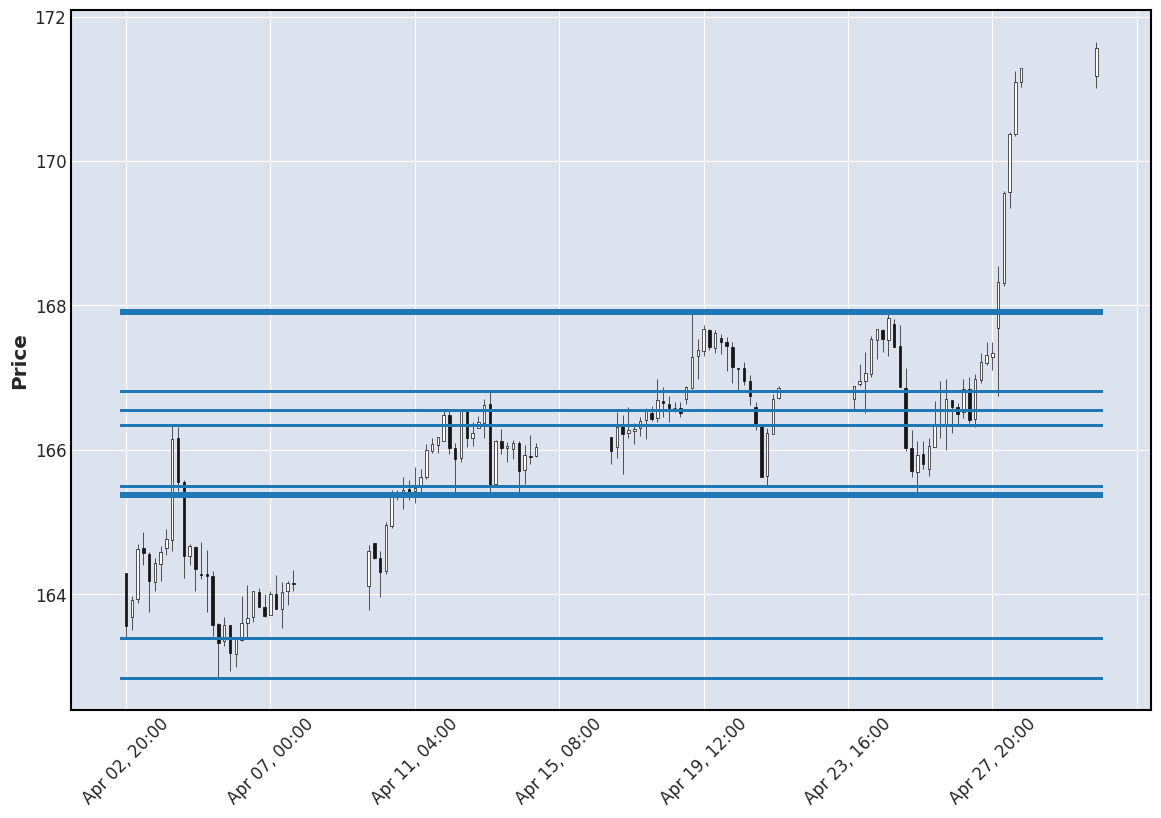

[163.4,
 166.34,
 162.84,
 166.55,
 165.36,
 166.81,
 165.38,
 167.93,
 165.5,
 167.9,
 165.4]

In [ ]:
df_2 = orig_df.loc['2023-04-01':'2023-04-30'].resample('4H').agg(d_ohlc)

mpf.plot(
    df,
    figsize=(15,10),
    type='candle',
    hlines=psar['TPrice'].dropna().tolist()
    )
psar['TPrice'].dropna().tolist()

In [ ]:
print(df.loc['2023-04-12':'2023-04-15']['Low'])
print(df_2.loc['2023-04-15':]['Low'].min())

<DTYYYYMMDD>_<TIME>
2023-04-12 00:00:00    166.12
2023-04-12 04:00:00    165.95
2023-04-12 08:00:00    165.36
2023-04-12 12:00:00    165.83
2023-04-12 16:00:00    166.04
2023-04-12 20:00:00    166.06
2023-04-13 00:00:00    166.31
2023-04-13 04:00:00    166.16
2023-04-13 08:00:00    165.38
2023-04-13 12:00:00    165.48
2023-04-13 16:00:00    165.94
2023-04-13 20:00:00    165.83
2023-04-14 00:00:00    165.87
2023-04-14 04:00:00    165.38
2023-04-14 08:00:00    165.53
2023-04-14 12:00:00    165.80
2023-04-14 16:00:00    165.90
Freq: 4H, Name: Low, dtype: float64
165.4


In [ ]:
tmp = psar[psar['PSARr_0.02_0.2']> 0]
tmp.interpolate()['PSARl_0.02_0.2'].dropna().tolist()

[162.84, 164.10000000000002, 165.36, 165.36]

In [ ]:
tmp

,PSARl_0.02_0.2,PSARs_0.02_0.2,PSARaf_0.02_0.2,PSARr_0.02_0.2,Trend,TPrice
<DTYYYYMMDD>_<TIME>,,,,,,
2023-04-04 12:00:00,NaN,166.34,0.02,1,Short,166.34
2023-04-07 00:00:00,162.84,NaN,0.02,1,Long,162.84
2023-04-12 08:00:00,NaN,166.55,0.02,1,Short,166.55
2023-04-12 12:00:00,165.36,NaN,0.02,1,Long,165.36
2023-04-13 08:00:00,NaN,166.81,0.02,1,Short,166.81


In [ ]:

def trade(amount,start,stop,lot,ls):
    amount = amount-lot
    if ls == 'Long':
        pos = stop-start
    elif ls == 'Short':
        pos = (stop-start)*-1
    amount += (1+pos)*lot
    return amount

In [ ]:
trade(amount=1000,start=166,stop=165,lot=10000,ls='Short')

11000

In [ ]:
tmp = psar[['Trend','TPrice']].dropna()

tmp['sub'] = tmp['TPrice']-tmp['TPrice'].shift(1)

amount=1000
r=amount*0.25
for i, v in tmp[['Trend','sub']].dropna().iterrows():
    if v['Trend'] == 'Long':
        amount = amount-r + r *1 v['sub']*-1
    elif v['Trend'] == 'Short':
        amount = amount-r+r *1* v['sub']

        # amount = trade(amount=amount,start=v['TPrice'],stop=psar.at(i,'TPrice').shift(1),ls='Short',lot=1000)

#tmp['sub'] = tmp['TPrice']-tmp['TPrice'].shift(1)
#tmp['sub'] = tmp.query('Trend == "Long"')['sub'] *-1

#for i,v in psar

In [ ]:
amount

2947.4999999999986

In [ ]:
orig_df.to_csv('./path/to/file.csv')